## Extract interesting features from a possible malicious URL 
#### Author: Shaghayegh Safar

By reading some of the materials provided by hoxhunt and some searching, I will explain what features we can extract from a URL. Below is structure of a URL which I used in this report (from https://arxiv.org/pdf/1510.06501.pdf): 
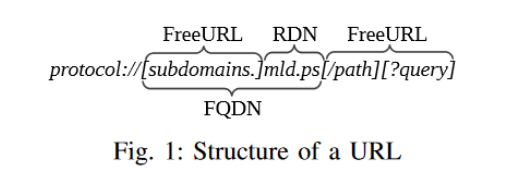 
    
- Usually phishing URLs are longer and have more combinations of terms. Attackers have fully control over FreeURL parts of the URL which contains subdomains of FQDN, path, and query. Therefore, we can consider the following as features: 

    - Length of the URL
    - Number of dots in FreeURL
    - Length of the FQDN 
    - Length of the mld
    - Count of terms in the URL
    - Count of terms in the mld 

- Another feature can be webpage content. Phishing webpages tend to have less text but more images and input fields. Therefore we can count the number of terms in the text, and the number pf images and input fields. 

- Number of hyperlinks can also be considered as a feature. Using a training data containing normal and malicious URL, we can learn if phishing webpages have more hyperlinks or less. 

- One of the features can be age of the webpage, since phishing webs have younger age than legitimate websites. However, this one was already covered as an example in the problem definition. 

- Protocols are very important part of the URL. https and http are the most secure protocols but there are other internet protocols such as FTP, DNS, DHCP, IMAP, SMTP, etc. If a URL does not have a proper protocol we can assume it might not be a legitimate websites. 

Below, I will extract some of the mentioned features and store them in a proper data structure.


In [1]:
import pandas as pd
import tldextract
import requests
import json
from urllib.parse import urlparse
from bs4 import BeautifulSoup
from bs4 import BeautifulSoup
import re
import urllib.request


def get_url_length(url):
    #Given a url calculates the length of that url
    #input: URL of a webpage 
    #output: an integer which shows the length of the input url
    return len(url)


def get_dots_in_freeurl_length(url):
    #Given a url calculates the number of dots in FreeURL 
    #(subdomains, path, query, Parameters for last path element)
    #input: URL of a webpage 
    #output: an integer which shows the number of dots in FreeURL of the input url 
    
    URL = urlparse(url)
    #checks if the url is proper, for example if it is a simple string "abc" 
    if URL.hostname:
        subdom_url = URL.hostname.split('.')[0]
    else:
        subdom_url = ""
    path_url = URL.path
    params_url = URL.params
    query_url = URL.query
    frag_url = URL.fragment
    freeurl = subdom_url+path_url+params_url+query_url+frag_url
    return freeurl.count('.')


def get_fqdn_length(url):
    #Given a url calculates the length of FQDN
    #input: URL of a webpage 
    #output: an integer which shows the length of the FQDN of the input url 
    return len(urlparse(url).netloc)


def get_mld_length(url):
    #Given a url calculates the length of the second-level domain (mld)
    #input: URL of a webpage 
    #output: an integer which shows the length of the mld of the input url  
    
    URL = urlparse(url)
    #checks if the url is proper, for example if it is a simple string "abc" 
    if URL.hostname: 
        mld = URL.hostname.split('.')[1]
    else:
        mld = ""
    return len(mld)

#Age of the domain: implemented by hoxhunt 
def get_domain_age_in_days(domain):
    show = "https://input.payapi.io/v1/api/fraud/domain/age/" + domain
    data = requests.get(show).json()
    return data['result'] if 'result' in data else None
def parse_domain_from_url(url):
    t = urlparse(url).netloc
    return '.'.join(t.split('.')[-2:])
def analyze_url(url):
    age_in_days_feature = get_domain_age_in_days(parse_domain_from_url(url))
    return age_in_days_feature


def get_num_of_img(url):
    #Given a url count the number of images in the corresponding webpage
    #input: URL of a webpage 
    #output: an integer which shows the number of images in the webpage. 
    #If the URL is not valid returns None.
    
    # some urls cannot be open, they have 404 not found error or... . We need try catch to avoid exceptions.
    try: 
        r = requests.get(url)
        data = r.text
        soup = BeautifulSoup(data)
        img = soup.findAll('img')
        return len(img)
    except: 
        print("An unexpected error happened for ", url)
        return None

def get_num_inputform(url):
    #Given a url calculates the number of input frames in the corresponding webpage
    #input: URL of a webpage 
    #output: an integer which shows the number of input frames in the webpage. 
    #If the URL is not valid returns None.
    try:
        r = requests.get(url)
        data = r.text
        soup = BeautifulSoup(data)
        form = soup.find('form')
        #form might be None so:
        if form!=None: 
            fields = form.findAll('input')
        else: 
            fields = ''
        return len(fields)   
    except: 
        print("An unexpected error happened for ", url)
        return None
    
def get_num_word(url):
    #Given a url calculates the number of words in the corresponding webpage
    #input: URL of a webpage 
    #output: an integer which shows the number of texts in the webpage. If the URL is not valid returns None.
    try:
        html = urllib.request.urlopen(url).read()
        soup = BeautifulSoup(html)
        for script in soup(["script", "style"]):
            script.decompose()
        strips = list(soup.stripped_strings)  
        return len(strips)
    except: 
        print("An unexpected error happened for ", url)
        return None
    

def is_https(url):
    # checks if given url has a https protocol
    #input: URL of a webpage 
    #output: A boolean value as True or False. Returns True if the URL has https protocol 
    protocol = urlparse(url).scheme
    return (protocol=='https')
        

In [2]:
def url_to_features(url):
    # implements all the feature functions on a given URL
    #input: URL of a webpage 
    #output: A dictionary where keys are features and values are values of features 
    dic = {}
    dic['url'] = url
    dic['len_url'] = get_url_length(url)
    dic['num_dots_in_freeurl'] = get_dots_in_freeurl_length(url)
    dic['len_FQDN'] = get_fqdn_length(url)
    dic['len_mld'] = get_mld_length(url)
    dic['age_domain'] = analyze_url(url)
    dic['num_img'] = get_num_of_img(url)
    dic['num_inputframes'] = get_num_inputform(url)
    dic['num_words'] = get_num_word(url)
    dic['is_https'] = is_https(url)
    return dic

In [3]:
url_examples = ["https://www.slideshare.net/weaveworks/client-side-monitoring-with-prometheus",
                "http://cartaobndes.gov.br.cv31792.tmweb.ru/",
                "https://paypal.co.uk.yatn.eu/m/",
                "http://college-eisk.ru/cli/",
                "https://dotpay-platnosc3.eu/dotpay/",
                "https://www.google.fi",
                "https://www.wikipedia.org/",
                "https://www.google.fi/jnj.sn;dk?loo.k#lol",
                "abc"
               ]

feature_list = []
for url in url_examples: 
    feature_list.append(url_to_features(url))
data = pd.DataFrame(feature_list)
data

An unexpected error happened for  http://cartaobndes.gov.br.cv31792.tmweb.ru/
An unexpected error happened for  http://cartaobndes.gov.br.cv31792.tmweb.ru/
An unexpected error happened for  http://cartaobndes.gov.br.cv31792.tmweb.ru/
An unexpected error happened for  https://paypal.co.uk.yatn.eu/m/
An unexpected error happened for  https://paypal.co.uk.yatn.eu/m/
An unexpected error happened for  https://paypal.co.uk.yatn.eu/m/
An unexpected error happened for  http://college-eisk.ru/cli/
An unexpected error happened for  https://dotpay-platnosc3.eu/dotpay/
An unexpected error happened for  https://dotpay-platnosc3.eu/dotpay/
An unexpected error happened for  https://dotpay-platnosc3.eu/dotpay/
An unexpected error happened for  https://www.google.fi/jnj.sn;dk?loo.k#lol
An unexpected error happened for  abc
An unexpected error happened for  abc
An unexpected error happened for  abc


,url,len_url,num_dots_in_freeurl,len_FQDN,len_mld,age_domain,num_img,num_inputframes,num_words,is_https
0,https://www.slideshare.net/weaveworks/client-s...,76,0,18,10,5106.0,53.0,2.0,251.0,True
1,http://cartaobndes.gov.br.cv31792.tmweb.ru/,43,0,35,3,5021.0,NaN,NaN,NaN,False
2,https://paypal.co.uk.yatn.eu/m/,31,0,20,2,NaN,NaN,NaN,NaN,True
3,http://college-eisk.ru/cli/,27,0,15,2,3089.0,0.0,0.0,NaN,False
4,https://dotpay-platnosc3.eu/dotpay/,35,0,19,2,NaN,NaN,NaN,NaN,True
5,https://www.google.fi,21,0,13,6,NaN,2.0,10.0,27.0,True
6,https://www.wikipedia.org/,26,0,17,9,7014.0,1.0,4.0,450.0,True
7,https://www.google.fi/jnj.sn;dk?loo.k#lol,41,2,13,6,NaN,0.0,0.0,NaN,True
8,abc,3,0,0,0,NaN,NaN,NaN,NaN,False


Before using any machine learning method, it is better to take care of the NaN values. The functions are implemented to return None in case of an exception. One could think of returning a default value such as -1 for the cases where the function fails, however, I did not do that since this should be done only as a post processing after function calls. \
The following code first looks at how many Nans we have and then replaces those with -1 for the features that can have only positive values.


In [4]:
print("Number of nulls per feature:")
print(data.isnull().sum())
data.fillna(-1 , inplace =True)
data

Number of nulls per feature:
url                    0
len_url                0
num_dots_in_freeurl    0
len_FQDN               0
len_mld                0
age_domain             5
num_img                4
num_inputframes        4
num_words              6
is_https               0
dtype: int64


,url,len_url,num_dots_in_freeurl,len_FQDN,len_mld,age_domain,num_img,num_inputframes,num_words,is_https
0,https://www.slideshare.net/weaveworks/client-s...,76,0,18,10,5106.0,53.0,2.0,251.0,True
1,http://cartaobndes.gov.br.cv31792.tmweb.ru/,43,0,35,3,5021.0,-1.0,-1.0,-1.0,False
2,https://paypal.co.uk.yatn.eu/m/,31,0,20,2,-1.0,-1.0,-1.0,-1.0,True
3,http://college-eisk.ru/cli/,27,0,15,2,3089.0,0.0,0.0,-1.0,False
4,https://dotpay-platnosc3.eu/dotpay/,35,0,19,2,-1.0,-1.0,-1.0,-1.0,True
5,https://www.google.fi,21,0,13,6,-1.0,2.0,10.0,27.0,True
6,https://www.wikipedia.org/,26,0,17,9,7014.0,1.0,4.0,450.0,True
7,https://www.google.fi/jnj.sn;dk?loo.k#lol,41,2,13,6,-1.0,0.0,0.0,-1.0,True
8,abc,3,0,0,0,-1.0,-1.0,-1.0,-1.0,False


## Discussion
To understand the importance of the propose features, we can implement machine learning methods, such as logistic regression, on a training data set containing both safe and malicious example URLs (after performing the proposed feature engineering functions and also ignoring url columns in the final data frame). This can easily be done by using a library such as Scikit-learn on the mentioned data set. We can then look at the weights of features in the model to assess the importance of each of the proposed features for the task of prediction safe vs malicious URL. 


Advanced next steps: We can also use NLP methods to read the content of each URL and clustering them into different topics. These topics can also be added as features and be used in the mentioned machine learning exercise.


### Acknowledgement
For this report I used the following papers: 
- Know Your Phish: Novel Techniques for Detecting Phishing Sites and their Targets: https://arxiv.org/pdf/1510.06501.pdf
- DeltaPhish: Detecting Phishing Webpages in Compromised Websites: https://arxiv.org/pdf/1707.00317.pdf

And some useful websites like: 
- awesome-threat-intelligence: https://github.com/hslatman/awesome-threat-intelligence

